## Part I: Data Cleaning and Exploration

### Step 1: import dependencies

In [95]:
#import dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc

### Step 2: read csv file, observe data, and handle missing values

In [96]:
# read the csv file into a pandas dataframe
allDataClean = pd.read_csv("cardioRiskDataset.csv",header=0)

# preview dataset
allDataClean.head()

,ID,Gender,Age,EverMarried,WorkType,ResidenceType,AvgGlucose,BMI,SmokingStatus,Risk
0,53882,Male,74.0,Yes,Private,Rural,70.09,27.4,never smoked,3
1,712,Female,82.0,No,Private,Rural,84.03,26.5,formerly smoked,3
2,53401,Male,71.0,No,Govt_job,Rural,216.94,30.9,never smoked,3
3,37651,Female,69.0,No,Self-employed,Urban,72.17,36.8,never smoked,3
4,60739,Female,79.0,No,Self-employed,Rural,60.94,NaN,never smoked,3


In [97]:
# delete ID column because it won't be useful for machine learning
del allDataClean["ID"]

# view dataset information - specifically datatypes
allDataClean.info()

# Notice that there are missing values in BMI and Smoking Status.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 9 columns):
Gender           43400 non-null object
Age              43400 non-null float64
EverMarried      43400 non-null object
WorkType         43400 non-null object
ResidenceType    43400 non-null object
AvgGlucose       43400 non-null float64
BMI              41938 non-null float64
SmokingStatus    30108 non-null object
Risk             43400 non-null int64
dtypes: float64(3), int64(1), object(5)
memory usage: 3.0+ MB


About 30% of the Smoking Status data is missing; because it's more than 10% of the data, we will delete the column. <br>
About 3% of the BMI data is missing; because it's less than 10% of the data, we will impute it. <br>

In [98]:
# remove Smoking Status column from dataframe
del allDataClean["SmokingStatus"]

# Impute missing BMI Data
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(allDataClean[["BMI"]])
allDataClean['BMI'] = imputer.transform(allDataClean[['BMI']]).ravel()

allDataClean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 8 columns):
Gender           43400 non-null object
Age              43400 non-null float64
EverMarried      43400 non-null object
WorkType         43400 non-null object
ResidenceType    43400 non-null object
AvgGlucose       43400 non-null float64
BMI              43400 non-null float64
Risk             43400 non-null int64
dtypes: float64(3), int64(1), object(4)
memory usage: 2.6+ MB


C:\Users\Cnellis\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


### Step 3: Explore target variable's proportion in dataset

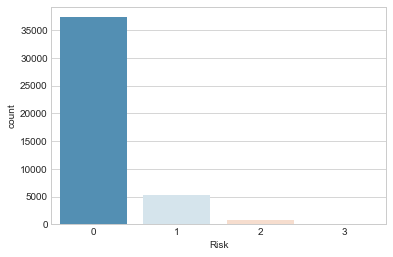

In [99]:
# view initial proportion of risk factor among population
sns.set_style('whitegrid')
sns.countplot(x='Risk',data=allDataClean,palette='RdBu_r')

In [100]:
# To increase balance of higher risk to lower risk, will group risk levels 1, 2, and 3 together as high risk and 0 as low risk:
allDataClean['Risk'] = allDataClean['Risk'].replace({0: 'low', 1: 'high', 2: 'high', 3: 'high'})

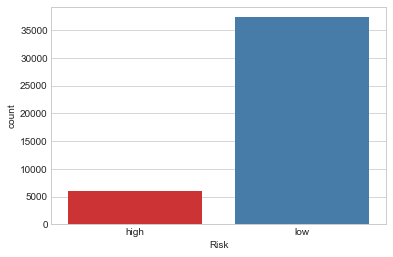

In [101]:
# Now, view new proportion of risk factor among population
sns.set_style('whitegrid')
sns.countplot(x='Risk',data=allDataClean,palette='Set1')

In [102]:
allDataClean.groupby('Risk').count()

,Gender,Age,EverMarried,WorkType,ResidenceType,AvgGlucose,BMI
Risk,,,,,,,
high,6066,6066,6066,6066,6066,6066,6066
low,37334,37334,37334,37334,37334,37334,37334


the dataset is still a bit unbalanced but is acceptable as higher risk for marjor cardio diseases  accounts for about 13% of the dataset.

To be balanced, 50% of our population would have high risk vs. 50% would have low risk.

Being unbalanced will influence an SVM model. 

##### In Step 9, (after feature selection), we use the Imbalanced-Learn library (built on top of Scikit-Learn) using the SMOTE algorithm to create a balanced dataset through oversampling

### Step4: Explore and Engineer Variables for Feature Selection

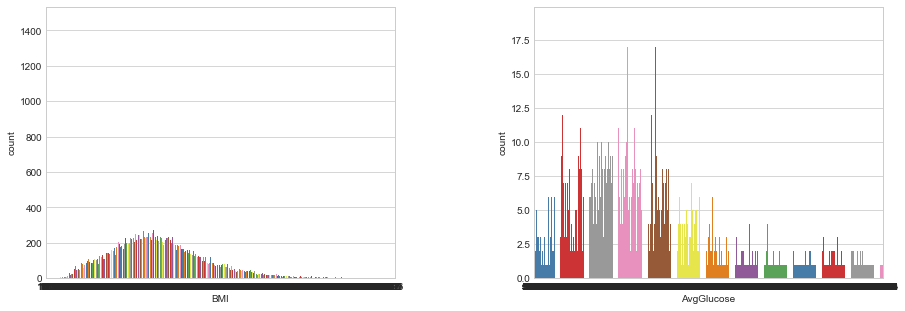

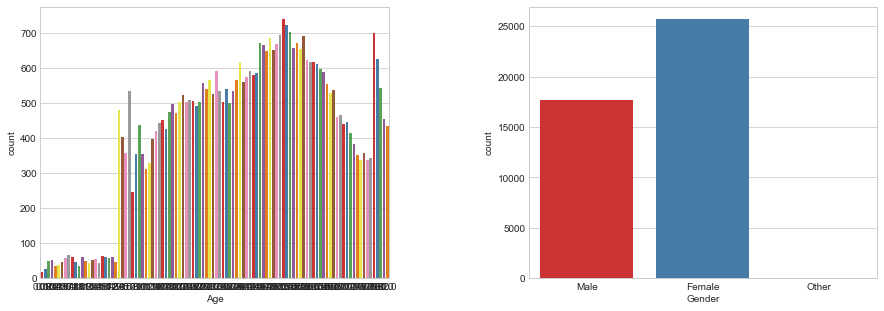

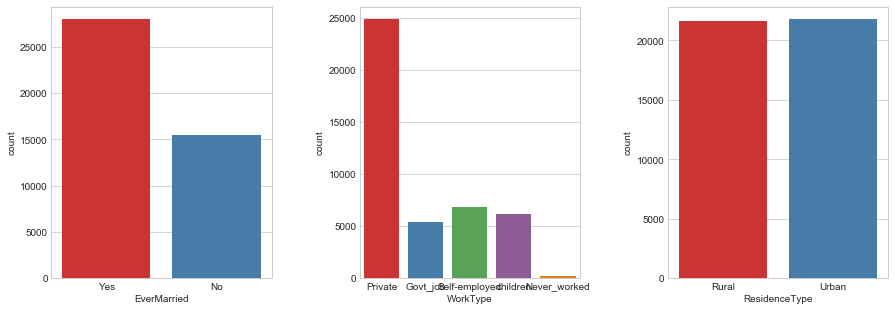

In [103]:
# view count by attribute
fig, axs = plt.subplots(ncols=2)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='BMI',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='AvgGlucose',data=allDataClean,palette='Set1', ax=axs[1])

fig, axs = plt.subplots(ncols=2)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='Age',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='Gender',data=allDataClean,palette='Set1',ax=axs[1])

fig, axs = plt.subplots(ncols=3)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='EverMarried',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='WorkType',data=allDataClean,palette='Set1', ax=axs[1])
ax = sns.countplot(x='ResidenceType',data=allDataClean,palette='Set1', ax=axs[2])

observe that other gender and never_worked are underrepresented in Gender and Work Type

In [104]:
# delete 'other' category in gender since it's under-represented
allDataClean = allDataClean[allDataClean.Gender != 'Other']

# delete "Never_worked" category since under-represented
allDataClean = allDataClean[allDataClean.WorkType != 'Never_worked']

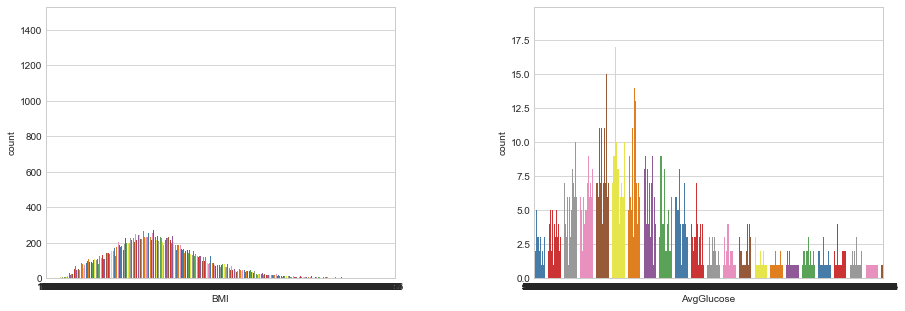

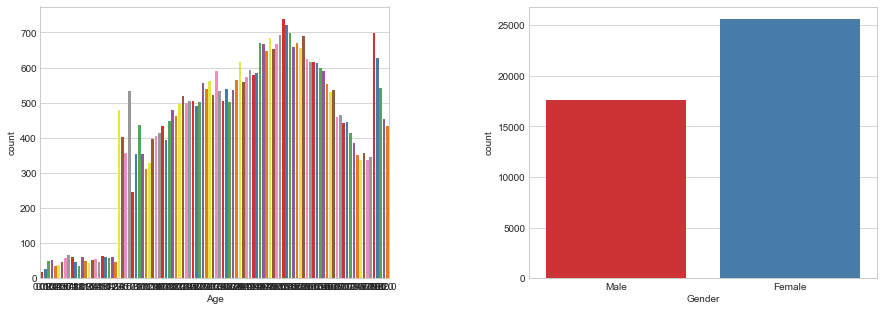

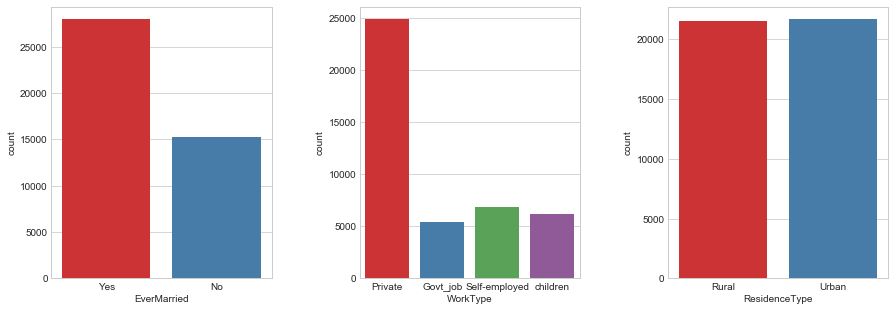

In [105]:
# view count by attribute
fig, axs = plt.subplots(ncols=2)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='BMI',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='AvgGlucose',data=allDataClean,palette='Set1', ax=axs[1])

fig, axs = plt.subplots(ncols=2)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='Age',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='Gender',data=allDataClean,palette='Set1',ax=axs[1])

fig, axs = plt.subplots(ncols=3)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='EverMarried',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='WorkType',data=allDataClean,palette='Set1', ax=axs[1])
ax = sns.countplot(x='ResidenceType',data=allDataClean,palette='Set1', ax=axs[2])

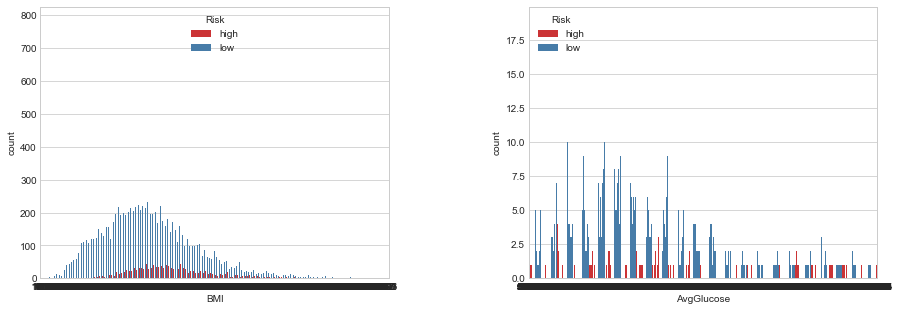

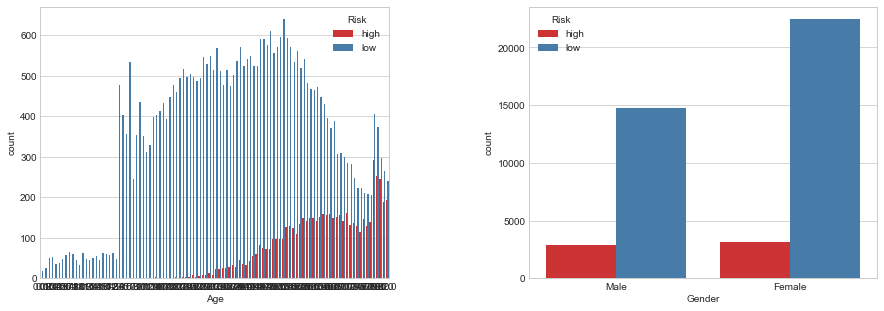

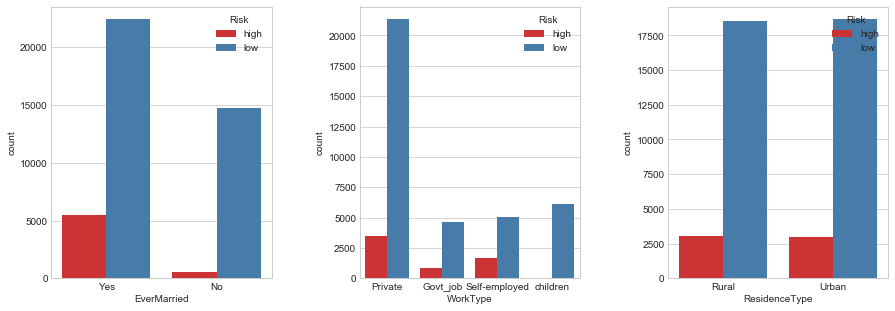

In [106]:
# view count of Risk by attribute (color = risk)
fig, axs = plt.subplots(ncols=2)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='BMI',hue='Risk',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='AvgGlucose',hue='Risk',data=allDataClean,palette='Set1', ax=axs[1])

fig, axs = plt.subplots(ncols=2)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='Age',hue='Risk',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='Gender',hue='Risk',data=allDataClean,palette='Set1',ax=axs[1])

fig, axs = plt.subplots(ncols=3)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.countplot(x='EverMarried',hue='Risk',data=allDataClean,palette='Set1', ax=axs[0])
ax = sns.countplot(x='WorkType',hue='Risk',data=allDataClean,palette='Set1', ax=axs[1])
ax = sns.countplot(x='ResidenceType',hue='Risk',data=allDataClean,palette='Set1', ax=axs[2])

### Step5: Binary Encoding: Transform Categorical Features into Numeric

In [107]:
# Convert categorical data to numbers using binary encoding with get_dummies
allDataEncoded = allDataClean.copy()
# encode gender
genderFeatures = ['Gender']
allDataEncoded = pd.get_dummies(allDataClean,columns=genderFeatures,drop_first=True)
# then encode ever married
marriedFeatures = ['EverMarried']
allDataEncoded2 = pd.get_dummies(allDataEncoded,columns=marriedFeatures,drop_first=True)
# then encode work
workFeatures = ['WorkType']
allDataEncoded3 = pd.get_dummies(allDataEncoded2,columns=workFeatures,drop_first=True)
# then encode risk
encodeRisk = ['Risk']
allDataEncoded4 = pd.get_dummies(allDataEncoded3,columns=encodeRisk,drop_first=True)
# then encode res type
encodeRes = ['ResidenceType']
allDataEncoded7 = pd.get_dummies(allDataEncoded4,columns=encodeRes,drop_first=True)

# observe descriptive statistics related to new dummy variables
allDataEncoded7.describe()

,Age,AvgGlucose,BMI,Gender_Male,EverMarried_Yes,WorkType_Private,WorkType_Self-employed,WorkType_children,Risk_low,ResidenceType_Urban
count,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000,43212.000000
mean,42.319948,104.526833,28.615716,0.408405,0.646256,0.574539,0.157202,0.142414,0.859645,0.501203
std,22.508317,43.162225,7.641037,0.491544,0.478137,0.494418,0.363995,0.349478,0.347359,0.500004
min,0.080000,55.000000,10.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,77.540000,23.400000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,44.000000,91.590000,28.100000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,60.000000,112.100000,32.700000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,82.000000,291.050000,97.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [108]:
# view encoded dataset information again
allDataEncoded7.info() 
# observe that 4 variables are categorical and need to be converted

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43212 entries, 0 to 43399
Data columns (total 10 columns):
Age                       43212 non-null float64
AvgGlucose                43212 non-null float64
BMI                       43212 non-null float64
Gender_Male               43212 non-null uint8
EverMarried_Yes           43212 non-null uint8
WorkType_Private          43212 non-null uint8
WorkType_Self-employed    43212 non-null uint8
WorkType_children         43212 non-null uint8
Risk_low                  43212 non-null uint8
ResidenceType_Urban       43212 non-null uint8
dtypes: float64(3), uint8(7)
memory usage: 2.9 MB


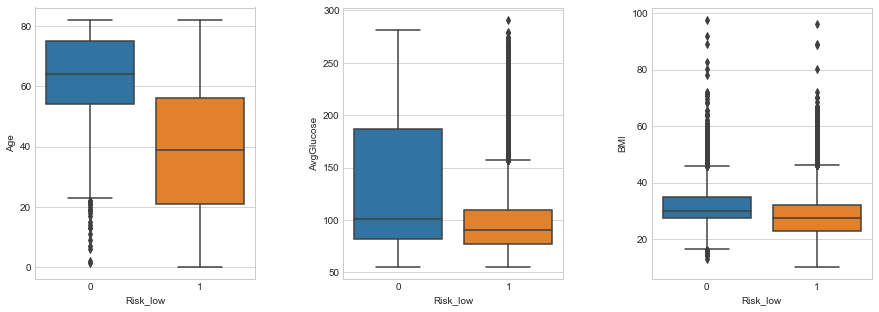

In [109]:
# explore outliers of continuous variables
fig, axs = plt.subplots(ncols=3)
sns.set_style('whitegrid')
fig.set_size_inches(15, 5)
fig.subplots_adjust(hspace=0.6, wspace=0.4)
ax = sns.boxplot(x="Risk_low", y="Age", data=allDataEncoded7, ax=axs[0])
ax = sns.boxplot(x="Risk_low", y="AvgGlucose", data=allDataEncoded7, ax=axs[1])
ax = sns.boxplot(x="Risk_low", y="BMI", data=allDataEncoded7, ax=axs[2])

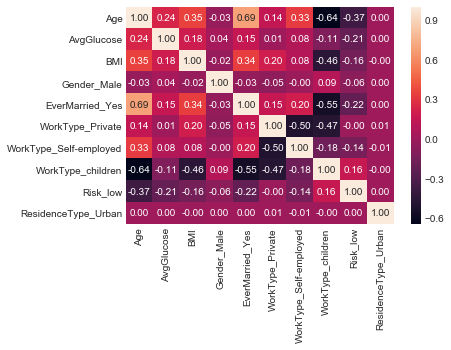

In [110]:
# explore multicolinearity of encoded data - in case consider using Naive Beyes model
sns.heatmap(allDataEncoded7.corr(), annot=True, fmt=".2f")
plt.show()

looks like age is correlated with work type: "children", and marriage status,
which makes sense as individuals under 18 won't be working or married

In [114]:
# restrict age to greater than or equal to 20
# because <20 might influence marriage and work status
allDataClean = allDataClean[allDataClean.Age >= 20]

##### Based on Steps 1-5 we have a basic understanding of the attributes' distributions, relationships, and outliers and are one step closer to concluding which features to include in our final model.

##### Next, we will split the data to build a decision tree and random forest in order to numerically observe the most important features.

### Step6: Split data into training set and testing set for evaluating feature importance

C:\Users\Cnellis\AppData\Roaming\Python\Python36\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


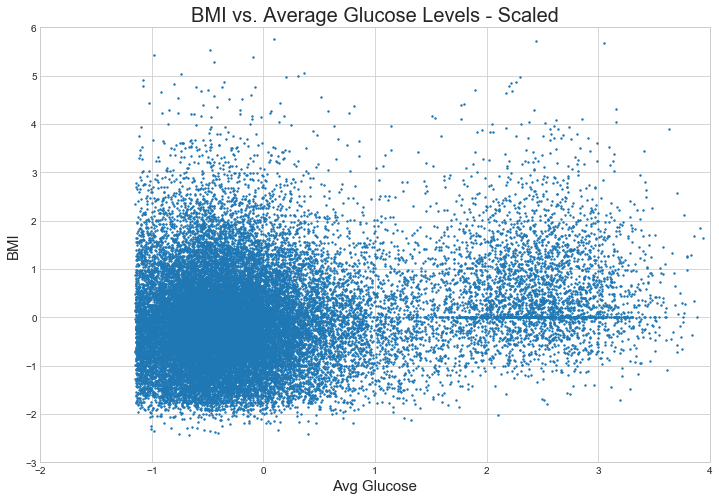

In [132]:
from sklearn.model_selection import train_test_split
X = allDataEncoded7.drop('Risk_low',axis=1)
y = allDataEncoded7['Risk_low']
y = np.array(y).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=71, stratify=y)

# normalize
sds = StandardScaler()
sds.fit(X_train)
X_train = sds.transform(X_train)
X_test = sds.transform(X_test)

plt.figure(figsize=(12,8))
plt.scatter(X_train_scaled[:,1], X_train_scaled[:,2], s=2)
plt.xlim(-2,4)
plt.ylim(-3,6)
plt.xlabel("Avg Glucose",fontsize=15)
plt.ylabel("BMI",fontsize=15)
plt.title('BMI vs. Average Glucose Levels - Scaled', fontsize=20)
plt.show() 

### Step 7: train a decision tree model  to evaluate feature importance

In [133]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

# Create an instance of DecisionTreeClassifier() called dtree and fit it to the training data.
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

#### predict and evaluate decision tree 

# create predictions from the test set
predictions = dtree.predict(X_test)

# create a classification report and a coonfusion matrix
# from sklearn.metrics import classification_report,confusion_matrix
# print(classification_report(y_test,predictions))

# print(confusion_matrix(y_test,predictions))

# print(f"Training Data Score: {dtree.score(X_train, y_train)}")
print(f"Average Accuracy Score of Testing Data: {dtree.score(X_test, y_test)}")

import os
import time
import sys

# use decision tree to consider feature importance
for i in range(3):
    
    t0 = time.time()
    clf = DecisionTreeClassifier()

    clf.fit(X_train, y_train)
    t1 = time.time()
    
    ypred = clf.predict(X_test)
    scores = roc_auc_score(y_test, ypred)
    
    print(f"Decision tree {i+1} took {t1-t0} seconds to train and got a score of {scores}")
    print()
    print("And here are the top features: ")
    c = X.columns 
    for cfi in zip(c, clf.feature_importances_):
        print(cfi)
    print()

Average Accuracy Score of Testing Data: 0.8041284828288439
Decision tree 1 took 0.2349092960357666 seconds to train and got a score of 0.6087208251782147

And here are the top features: 
('Age', 0.2745609459643534)
('AvgGlucose', 0.3653303980664804)
('BMI', 0.2465635561230332)
('Gender_Male', 0.021188876869205057)
('EverMarried_Yes', 0.01504333621808186)
('WorkType_Private', 0.0245207774786505)
('WorkType_Self-employed', 0.020553636586046233)
('WorkType_children', 0.0)
('ResidenceType_Urban', 0.032238472694149485)

Decision tree 2 took 0.2137911319732666 seconds to train and got a score of 0.6042852763516284

And here are the top features: 
('Age', 0.27651759887692334)
('AvgGlucose', 0.3695584138172287)
('BMI', 0.2456549675558101)
('Gender_Male', 0.01998523361768862)
('EverMarried_Yes', 0.015014157344038243)
('WorkType_Private', 0.02234931878611801)
('WorkType_Self-employed', 0.02102585575894496)
('WorkType_children', 0.0)
('ResidenceType_Urban', 0.029894454243248027)

Decision tree 3 

Based on decision tree, looks like glucose, bmi, and age are most important in predicting risk <br>
followed by residence type, worktype, marriage status and gender <br>

keep in mind that the average accuracy of this decision tree is only about 77%

### Step 8: Train a random forest model to evaluate potential features

In [134]:
# create an instance of the random forest classifer class 
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)
print(f"Average Accuracy Score of Testing Data: {rfc.score(X_test, y_test)}")
importances = rfc.feature_importances_
feature_importances = pd.DataFrame(rfc.feature_importances_, index = X.columns, columns=['importance']).sort_values('importance',ascending=False)
print(feature_importances)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Average Accuracy Score of Testing Data: 0.8518929926872165
                        importance
AvgGlucose                0.352709
BMI                       0.288275
Age                       0.270226
EverMarried_Yes           0.022834
ResidenceType_Urban       0.021024
Gender_Male               0.015721
WorkType_Private          0.013767
WorkType_Self-employed    0.012335
WorkType_children         0.003111


Based on random forest feature evaluation, 
- Glucose, BMI, and Age appear are most useful in predicting cardiovascular risk,
- followed by Marriage Status, residence type, and gender, 
- while work type appears to be least effective feature in cardiovascular risk prediction.

Because random forest's average accuracy is a bit higher, we will give more weight to it's ranking of feature importance

##### Decide to use Glucose, BMI, Age, Marriage Status, Residence Type, and Gender for Models

### Step 9. Create a dataframe to hold selected 'cleaned' variables for models

In [135]:
CleanedDataForModels = allDataEncoded7[['Risk_low', 'AvgGlucose', 'BMI', 'Age', 'EverMarried_Yes', 'ResidenceType_Urban', 'Gender_Male']]
CleanedDataForModels.to_csv("CleanedDataForModels.csv")
CleanedDataForModels.head()

,Risk_low,AvgGlucose,BMI,Age,EverMarried_Yes,ResidenceType_Urban,Gender_Male
0,0,70.09,27.400000,74.0,1,0,1
1,0,84.03,26.500000,82.0,0,0,0
2,0,216.94,30.900000,71.0,0,0,1
3,0,72.17,36.800000,69.0,0,1,0
4,0,60.94,28.605038,79.0,0,0,0


---

## Part II: Use Selected Variables to Build Models

### Step10: Split dataset and create a balanced sample through over-sampling with SMOTE

In [ ]:
# use the Imbalanced-Learn library (built on top of Scikit-Learn) using the SMOTE algorithm 
# to create a balanced sample.
!pip install -U imbalanced-learn
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
 
X = CleanedDataForModels.drop('Risk_low',axis=1)
y = CleanedDataForModels['Risk_low']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=71, stratify=y)
sm = SMOTE(random_state=12, ratio = 1.0)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# create the resampled datasets
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

# Now, the dataset should be closer to 50-50
# X_train_res.groupby('ResidenceType_Urban').count()
# y_train.describe()


### Step11: Build logistic regression, optimize on accuracy.

In [ ]:
from sklearn.linear_model import LogisticRegression
# train the model with standard data
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

# Now predict against standard test data
predictions = logmodel.predict(X_test)

# print classification report
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

In [ ]:
# print confusion matrix
print(confusion_matrix(y_test,predictions))

In [ ]:
# Create/Train logistic model with the *re-sampled* data
logmodelResampled = LogisticRegression()
logmodelResampled.fit(x_train_res,y_train_res)

# predict against standard test data
predictions = logmodelResampled.predict(X_test)
print(classification_report(y_test,predictions))

In [ ]:
# print confusion matrix for re-sampled data
print(confusion_matrix(y_test,predictions))

In [ ]:
# compare results from initial and re-sampled data

### Step 12: Build Support Vector Classifier, optimize on accuracy

In [138]:
from sklearn.svm import SVC
svc_model = SVC()
svc_model.fit(X_train,y_train)

# Now predict values for the testing data
predictions = svc_model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
# print classification report
print(classification_report(y_test,predictions))

C:\Users\Cnellis\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.43      0.08      0.13      1516
           1       0.87      0.98      0.92      9287

   micro avg       0.86      0.86      0.86     10803
   macro avg       0.65      0.53      0.53     10803
weighted avg       0.81      0.86      0.81     10803



In [139]:
# print confusion matrix
print(confusion_matrix(y_test,predictions))

[[ 119 1397]
 [ 158 9129]]


In [140]:
# run SVC with re-sampled data
from sklearn.svm import SVC
svc_model_resampled = SVC()
svc_model_resampled.fit(X_train_res,y_train_res)

# Now predict values for the standard testing data
predictions = svc_model_resampled.predict(X_test)
print(classification_report(y_test,predictions))

C:\Users\Cnellis\AppData\Roaming\Python\Python36\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

           0       0.29      0.44      0.35      1516
           1       0.90      0.83      0.86      9287

   micro avg       0.77      0.77      0.77     10803
   macro avg       0.59      0.63      0.60     10803
weighted avg       0.81      0.77      0.79     10803



In [141]:
# compare results from initial and re-sampled data

### Step 13. Build Decision Trees

In [142]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

# Now predict values for the testing data
predictions = dtree.predict(X_test)
# print classification report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.31      0.34      0.33      1516
           1       0.89      0.88      0.88      9287

   micro avg       0.80      0.80      0.80     10803
   macro avg       0.60      0.61      0.61     10803
weighted avg       0.81      0.80      0.81     10803



In [143]:
# print confusion matrix
print(confusion_matrix(y_test,predictions))

[[ 520  996]
 [1143 8144]]


In [144]:
# build decision tree with re-sampled data
from sklearn.tree import DecisionTreeClassifier
dtree_resampled = DecisionTreeClassifier()
dtree_resampled.fit(X_train_res,y_train_res)

# Now predict values for the standard testing data
predictions = dtree_resampled.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.31      0.35      0.33      1516
           1       0.89      0.87      0.88      9287

   micro avg       0.80      0.80      0.80     10803
   macro avg       0.60      0.61      0.60     10803
weighted avg       0.81      0.80      0.80     10803



In [145]:
# print confusion matrix with re-sampled data
print(confusion_matrix(y_test,predictions))

[[ 537  979]
 [1217 8070]]


In [146]:
# compare results from initial and re-sampled data

### Step 14: Build Random Forest Classifier

In [147]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train,y_train)

# Now predict values for the testing data
predictions = rfc.predict(X_test)
# print classification report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.41      0.20      0.27      1516
           1       0.88      0.95      0.91      9287

   micro avg       0.85      0.85      0.85     10803
   macro avg       0.65      0.58      0.59     10803
weighted avg       0.81      0.85      0.82     10803



In [148]:
# print confusion matrix
print(confusion_matrix(y_test,predictions))

[[ 307 1209]
 [ 440 8847]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc_resampled = RandomForestClassifier(n_estimators=1000)
rfc_resampled.fit(X_train_res,y_train_res)

# Now predict values for the testing data
predictions = rfc_resampled.predict(X_test)
# print classification report
print(classification_report(y_test,predictions))

In [ ]:
# print confusion matrix for resampled data
print(confusion_matrix(y_test,predictions))